In [1]:
import time 
from subprocess import call
import numpy as np
import matplotlib.pyplot as plt
# import cv2
import h5py
import os
import copy

from tqdm import tqdm
from PIL import Image
from sklearn.preprocessing import StandardScaler

import webdataset as wds
import sys

from nsd_access import NSDAccess
nsd_path = '/scratch/gpfs/KNORMAN/natural-scenes-dataset'
nsda = NSDAccess(nsd_path)

import nibabel as nib

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:",device)

device: cuda


In [2]:
tmp = '/scratch/gpfs/KNORMAN'

shared1000 = np.load("shared1000.npy")

In [3]:
# import pandas as pd
# shared1000 = pd.read_csv(f'{tmp}/natural-scenes-dataset/nsddata/experiments/nsd/nsd_stim_info_merged.csv')['shared1000'].values
# np.save("shared1000",shared1000)

In [4]:
# from torchvision import transforms

# # load orig images
# f = h5py.File(f'{tmp}/natural-scenes-dataset/nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5', 'r')
# images = f['imgBrick']

# image_matrix = None
# for ii in tqdm(range(0,73000,200)):
#     im = images[ii:ii+200]
#     imT = (transforms.Resize((224,224))(torch.Tensor(im).permute(0,-1,1,2)) / 255).half()
#     if image_matrix is None:
#         image_matrix = imT
#     else:
#         image_matrix = torch.vstack((image_matrix, imT))
        
# image_matrix = image_matrix.numpy()
# print(image_matrix.shape)

# with h5py.File('coco_images_224_float16.hdf5', 'w') as file:
#     file.create_dataset('images', data=image_matrix, shape=image_matrix.shape, dtype=np.float16)

In [5]:
# # spatial coordinates
# # https://github.com/huzeyann/MemoryEncodingModel/blob/127b99c73634f89c570eaac67d44ea554b48b59e/mem/point_pe.py
# def sinusoidal(positions, features=16, periods=10000):
#     """Encode `positions` using sinusoidal positional encoding

#     Args:
#         positions: tensor of positions
#         features: half the number of features per position
#         periods: used frequencies for the sinusoidal functions

#     Returns:
#         Positional encoding of shape `(*positions.shape, features, 2)`
#     """
#     dtype = positions.dtype if positions.is_floating_point() else None
#     kwargs = dict(device=positions.device, dtype=dtype)
#     omega = torch.logspace(0, 1 / features - 1, features, periods, **kwargs)
#     fraction = omega * positions.unsqueeze(-1)
#     return torch.stack((fraction.sin(), fraction.cos()), dim=-1)

# def point_pe(points, low=0, high=1, steps=100, features=16, periods=10000):
#     """Encode points in bounded space using sinusoidal positional encoding

#     Args:
#         points: tensor of points; typically of shape (*, C)
#         low: lower bound of the space; typically of shape (C,)
#         high: upper bound of the space; typically of shape (C,)
#         steps: number of cells that split the space; typically of shape (C,)
#         features: half the number of features per position
#         periods: used frequencies for the sinusoidal functions

#     Returns:
#         Positional encoded points of the following shape:
#         `(*points.shape[:-1], points.shape[-1] * features * 2)`
#     """
#     positions = (points - low).mul_(steps / (high - low))
#     return sinusoidal(positions, features, periods).flatten(-3)

# def point_position_encoding(points, max_steps=100, features=16, periods=10000):
#     low = points.min(0).values
#     high = points.max(0).values
#     steps = high - low
#     steps *= max_steps / steps.max()
#     pe = point_pe(points, low, high, steps, features, periods)
#     return pe

# for sub in [0,1,2,3,4,5,6,7]:
#     subject=f'subj0{sub+1}'
#     subj=subject
#     print(subject)
#     tar=0
#     sess=tar+1

#     # pull single-trial betas and mask them
#     betas = nsda.read_betas(subject=subject, 
#                         session_index=sess, 
#                         trial_index=[], # empty list as index means get all for this session
#                         data_type='betas_fithrf', # GLMSingle beta2
#                         data_format='func1pt8mm') 

#     vox_include = np.load(f"vox_include_{subject}.npy")

In [3]:
downsampling = True
if downsampling: 
    from scipy.ndimage import convolve
    down_scale = 5 # 11 is 2cm, 5 is 1cm

In [3]:
downsampling, use_raw = False, False

In [7]:
# use_raw = True

# need to get the image onset times 

# raw_data = None
# for run in range(1,13):
#     if run < 10:
#         run = "0" + str(run)
#     raw_datum = nib.load(f"{nsd_path}/nsddata_rawdata/sub-01/ses-nsd01/func/sub-01_ses-nsd01_task-nsdcore_run-{run}_bold.nii.gz").get_fdata()
#     if raw_data is None:
#         raw_data = raw_datum
#     else:
#         raw_data = np.vstack((raw_data, raw_datum))
#     print(run, raw_data.shape)
    
# # time shift and take BOLD after 4.8 seconds
# # raw_data = raw_data[3:][::3]
# print(raw_data[3:][::3].shape)

In [9]:
for sub in [0]: #,1,2,3,4,5,6,7]:
    subject=f'subj0{sub+1}'
    subj=subject
    print(subject)
    
    abs_cnt = -1
    abs_notshared1000_cnt = -1
    abs_shared1000_cnt = -1
    
    # load coco 73k indices
    indices_path = "COCO_73k_subj_indices.hdf5"
    hdf5_file = h5py.File(indices_path, "r")
    indices = hdf5_file[f"{subj}"][:]

    nsessions_allsubj=np.array([40, 40, 32, 30, 40, 32, 40, 30])-3 # 3 sessions are withheld for algonauts 
    nsessions=nsessions_allsubj[sub];
    ntrials = 750*nsessions
    print(nsessions,ntrials)

    print(time.strftime("\nCurrent time: %H:%M:%S", time.localtime())) 
    
    file = f"/scratch/gpfs/KNORMAN/natural-scenes-dataset/nsddata/ppdata/{subject}/func1pt8mm/roi/nsdgeneral.nii.gz"
    nifti = nib.load(file) 
    mask = nifti.get_data()
    mask[mask<1] = 0 
    nsdgeneral_mask = mask
    
    file = f"/scratch/gpfs/KNORMAN/natural-scenes-dataset/nsddata/ppdata/{subject}/func1pt8mm/brainmask.nii.gz"
    nifti = nib.load(file) 
    mask = nifti.get_data()
    mask[mask<1] = 0 
    wholebrain_mask = mask + nsdgeneral_mask
    
    # only include below lines if you want to save the vox_include
    # vox_include = nsdgeneral_mask
    # vox_include = wholebrain_mask
#     np.save(f"vox_include_{subject}", vox_include)
    
    # vox_include = np.load(f"vox_include_{subject}.npy")
    # vox_include = vox_include.reshape(-1)

    for tar in tqdm(range(nsessions)):
        sess=tar+1
        
        behav = nsda.read_behavior(subject=subject, 
                    session_index=sess, 
                    trial_index=[]) 

        # pull single-trial betas and mask them
        betas = nsda.read_betas(subject=subject, 
                            session_index=sess, 
                            trial_index=[], # empty list as index means get all for this session
                            data_type='betas_fithrf', # GLMSingle beta2
                            data_format='func1pt8mm') 

        # betas = betas[mask]
        betas = np.moveaxis(betas,-1,0)
        
        vox_include = copy.deepcopy(wholebrain_mask)
        ncsnr = nib.load(f"{subject}_ncsnr.nii.gz").get_fdata()
        ncsnr[ncsnr<.15] = np.nan 
        if tar==0: print("voxels left:", len(vox_include[vox_include>0]))
        vox_include[np.isnan(ncsnr)] -= 1 # keep all nsdgeneral voxels even if they are below the threshold
        vox_include[vox_include<0] = 0
        if tar==0: print("voxels left after ncsnr thresholding:", len(vox_include[vox_include>0])) # subj01 = 49329
        
        if downsampling:
            kernel = np.ones((down_scale, down_scale, down_scale)) / (down_scale*down_scale*down_scale)
            
            # Pad data to make dimensions divisible by down_scale
            pad_dims = [(0, 0) if d == 750 else (0, down_scale - (d % down_scale)) for d in betas.shape]
            betas = np.pad(betas, pad_dims, mode='constant')
            vox_include = np.pad(vox_include, pad_dims[1:], mode='constant')
            
            assert betas.shape[1:] == vox_include.shape
            
#             shape = (750, betas.shape[1]//down_scale, betas.shape[2]//down_scale, betas.shape[3]//down_scale)
#             downsampled_betas = np.zeros(shape)
#             downsampled_mask = np.zeros((vox_include.shape[0]//down_scale, vox_include.shape[1]//down_scale, vox_include.shape[2]//down_scale))
            
#             assert downsampled_betas.shape[1:] == downsampled_mask.shape
            
    #####
            downsampled_betas = np.zeros((750, betas.shape[1]//down_scale, betas.shape[2]//down_scale, betas.shape[3]//down_scale))
            count_nonzero = np.zeros((750, betas.shape[1]//down_scale, betas.shape[2]//down_scale, betas.shape[3]//down_scale))
            binary_mask = (betas != 0).astype(float)
            
            downsampled_voxinclude = np.zeros((betas.shape[1]//down_scale, betas.shape[2]//down_scale, betas.shape[3]//down_scale))
            count_voxinclude = np.zeros((betas.shape[1]//down_scale, betas.shape[2]//down_scale, betas.shape[3]//down_scale))
            binary_inc = (vox_include != 0).astype(float)
            
            for t in range(750):
                downsampled_betas[t] = convolve(betas[t], kernel, mode='nearest')[::down_scale, ::down_scale, ::down_scale]
                count_nonzero[t] = convolve(binary_mask[t], kernel, mode='nearest')[::down_scale, ::down_scale, ::down_scale]
            downsampled_voxinclude = convolve(vox_include, kernel, mode='nearest')[::down_scale, ::down_scale, ::down_scale]
            count_voxinclude = convolve(binary_inc, kernel, mode='nearest')[::down_scale, ::down_scale, ::down_scale]
            
            # Element-wise division to get average, but only for non-zero counts
            downsampled_betas[count_nonzero != 0] /= count_nonzero[count_nonzero != 0]
            downsampled_voxinclude[count_voxinclude != 0] /= count_voxinclude[count_voxinclude != 0]
    #####
#             for t in range(750):
#                 for x in range(0, betas.shape[1] - down_scale, down_scale):
#                     for y in range(0, betas.shape[2] - down_scale, down_scale):
#                         for z in range(0, betas.shape[3] - down_scale, down_scale):
#                             chunk = betas[t, x:x+down_scale, y:y+down_scale, z:z+down_scale]
#                             count = np.count_nonzero(chunk)
#                             if count > 0:
#                                 downsampled_betas[t, x//down_scale, y//down_scale, z//down_scale] = np.sum(chunk) / count

#             for x in range(0, vox_include.shape[0] - down_scale, down_scale):
#                 for y in range(0, vox_include.shape[1] - down_scale, down_scale):
#                     for z in range(0, vox_include.shape[2] - down_scale, down_scale):
#                         chunk = vox_include[x:x+down_scale, y:y+down_scale, z:z+down_scale]
#                         downsampled_mask[x//down_scale, y//down_scale, z//down_scale] = np.mean(chunk)

            betas = downsampled_betas  
            vox_include = downsampled_voxinclude #downsampled_mask
            vox_include = vox_include.reshape(-1)
            
        betas = betas.reshape(len(betas),-1)
        betas = betas[:,vox_include.flatten().astype(bool)]
        shape = betas.shape
        scalar = StandardScaler(with_mean=True, with_std=True).fit(betas) 
        betas_mean = scalar.mean_
        betas_std = scalar.scale_

        betas = (betas - betas_mean) / betas_std
        betas = betas.reshape(shape).astype('float16') # (1, 15724)    
        
        globals()[f'betas_ses{sess}'] = betas  
        globals()[f'behav_ses{sess}'] = behav   
        print(betas.shape)
        
    for tar in range(nsessions):
        sess=tar+1
        
        if sess==1:
            betas_all = globals()[f'betas_ses{sess}']
        else:
            betas_all = np.vstack((betas_all,globals()[f'betas_ses{sess}']))
        print(betas_all.shape)
        
    if downsampling:
        with h5py.File(f'betas_9mm_{subject}_convolved.hdf5', 'w') as f:
            f.create_dataset('betas', data=betas_all)
    else:
        with h5py.File(f'betas_{subject}_thresholded_wholebrain.hdf5', 'w') as f:
            f.create_dataset('betas', data=betas_all)
        print(f"saved betas_{subject}_thresholded_wholebrain.hdf5")
        err
        
    os.makedirs(f"{tmp}/mindeyev2_wds/{subj}",exist_ok=True)
    os.makedirs(f"{tmp}/mindeyev2_wds/{subj}/train",exist_ok=True)
    os.makedirs(f"{tmp}/mindeyev2_wds/{subj}/test",exist_ok=True)
    sink1 = wds.TarWriter(f"{tmp}/mindeyev2_wds/{subj}/test/0.tar")
    for tar in tqdm(range(nsessions)):
        behav = globals()[f'behav_ses{tar+1}']
        
        sink2 = wds.TarWriter(f"{tmp}/mindeyev2_wds/{subj}/train/{tar}.tar")
        for i in range(len(behav)):
            abs_cnt += 1                

            trial_numbers = np.where(indices==indices[abs_cnt])[0]
            assert np.isin(abs_cnt,trial_numbers)
            trial_numbers[trial_numbers == abs_cnt] = -1 # current trial becomes negative 1
            if len(trial_numbers) == 1:
                trial_numbers = np.append(trial_numbers, -1)
                trial_numbers = np.append(trial_numbers, -1)
            if len(trial_numbers) == 2:
                trial_numbers = np.append(trial_numbers, -1)
            assert len(trial_numbers) == 3

            sess=tar+1
            behav = globals()[f'behav_ses{sess}']
            behav_matrix = np.ones((1, 17))*-1
            jjj=-1
            for j in range(1):
                jj = i-j
                jjj += 1

                if jj >= 0:
                    # change NaNs to negative-one integers
                    iscorrect = behav.iloc[jj]['ISCORRECT']
                    if np.isnan(iscorrect): iscorrect = -1

                    isoldcurrent = behav.iloc[jj]['ISOLDCURRENT']
                    if np.isnan(isoldcurrent): isoldcurrent = -1

                    iscorrectcurrent = behav.iloc[jj]['ISCORRECTCURRENT']
                    if np.isnan(iscorrectcurrent): iscorrectcurrent = -1

                    rt = behav.iloc[jj]['RT']
                    if np.isnan(rt): rt = -1

                    changemind = behav.iloc[jj]['CHANGEMIND']
                    if np.isnan(changemind): changemind = -1

                    button = behav.iloc[jj]['BUTTON']
                    if np.isnan(button): button = -1

                    total1 = behav.iloc[jj]['TOTAL1']
                    if np.isnan(total1): total1 = -1

                    total2 = behav.iloc[jj]['TOTAL2']
                    if np.isnan(total2): total2 = -1
                    
                    coco73 = int(behav.iloc[jj]['73KID'])-1
                    assert coco73 >= 0 and coco73 < 730000

                    behavior = {
                        "cocoidx": coco73, #0
                        "subject": sub+1,                          #1
                        "session": int(behav.iloc[jj]['SESSION']), #2
                        "run": int(behav.iloc[jj]['RUN']),         #3
                        "trial": int(behav.iloc[jj]['TRIAL']),     #4
                        "global_trial": (int(behav.iloc[jj]['SESSION'])-1)*750 + jj,        #5
                        "time": int(behav.iloc[jj]['TIME']),       #6
                        "isold": int(behav.iloc[jj]['ISOLD']),     #7
                        "iscorrect": iscorrect,                    #8
                        "rt": rt, # 0 = no RT                      #9
                        "changemind": changemind,                  #10
                        "isoldcurrent": isoldcurrent,              #11
                        "iscorrectcurrent": iscorrectcurrent,      #12
                        "total1": total1,   #13
                        "total2": total2,   #14
                        "button": button,                          #15
                        "shared1000": shared1000[int(behav.iloc[jj]['73KID'])-1], #16
                    }
                    
                    assert (int(behav.iloc[jj]['SESSION'])-1)*750 + jj >= 0
                    assert (int(behav.iloc[jj]['SESSION'])-1)*750 + jj < 27750

                    behav_matrix[jjj] = np.array(list(behavior.values()))
                    
            past_behav_matrix = np.ones((15, 17))*-1
            jjj=-1
            for j in range(1,16):
                jj = i-j
                jjj += 1

                if jj >= 0:
                    # change NaNs to negative-one integers
                    iscorrect = behav.iloc[jj]['ISCORRECT']
                    if np.isnan(iscorrect): iscorrect = -1

                    isoldcurrent = behav.iloc[jj]['ISOLDCURRENT']
                    if np.isnan(isoldcurrent): isoldcurrent = -1

                    iscorrectcurrent = behav.iloc[jj]['ISCORRECTCURRENT']
                    if np.isnan(iscorrectcurrent): iscorrectcurrent = -1

                    rt = behav.iloc[jj]['RT']
                    if np.isnan(rt): rt = -1

                    changemind = behav.iloc[jj]['CHANGEMIND']
                    if np.isnan(changemind): changemind = -1

                    button = behav.iloc[jj]['BUTTON']
                    if np.isnan(button): button = -1

                    total1 = behav.iloc[jj]['TOTAL1']
                    if np.isnan(total1): total1 = -1

                    total2 = behav.iloc[jj]['TOTAL2']
                    if np.isnan(total2): total2 = -1
                    
                    coco73 = int(behav.iloc[jj]['73KID'])-1
                    assert coco73 >= 0 and coco73 < 730000

                    behavior = {
                        "cocoidx": coco73, #0
                        "subject": sub+1,                          #1
                        "session": int(behav.iloc[jj]['SESSION']), #2
                        "run": int(behav.iloc[jj]['RUN']),         #3
                        "trial": int(behav.iloc[jj]['TRIAL']),     #4
                        "global_trial": (int(behav.iloc[jj]['SESSION'])-1)*750 + jj,        #5
                        "time": int(behav.iloc[jj]['TIME']),       #6
                        "isold": int(behav.iloc[jj]['ISOLD']),     #7
                        "iscorrect": iscorrect,                    #8
                        "rt": rt, # 0 = no RT                      #9
                        "changemind": changemind,                  #10
                        "isoldcurrent": isoldcurrent,              #11
                        "iscorrectcurrent": iscorrectcurrent,      #12
                        "total1": total1,   #13
                        "total2": total2,   #14
                        "button": button,                          #15
                        "shared1000": shared1000[int(behav.iloc[jj]['73KID'])-1], #16
                    }
                    
                    assert (int(behav.iloc[jj]['SESSION'])-1)*750 + jj >= 0
                    assert (int(behav.iloc[jj]['SESSION'])-1)*750 + jj < 27750

                    past_behav_matrix[jjj] = np.array(list(behavior.values()))
                    
            future_behav_matrix = np.ones((15, 17))*-1
            jjj=-1
            for j in range(1,16):
                jj = i+j
                jjj += 1

                if jj >= 0 and jj<750:
                    # change NaNs to negative-one integers
                    iscorrect = behav.iloc[jj]['ISCORRECT']
                    if np.isnan(iscorrect): iscorrect = -1

                    isoldcurrent = behav.iloc[jj]['ISOLDCURRENT']
                    if np.isnan(isoldcurrent): isoldcurrent = -1

                    iscorrectcurrent = behav.iloc[jj]['ISCORRECTCURRENT']
                    if np.isnan(iscorrectcurrent): iscorrectcurrent = -1

                    rt = behav.iloc[jj]['RT']
                    if np.isnan(rt): rt = -1

                    changemind = behav.iloc[jj]['CHANGEMIND']
                    if np.isnan(changemind): changemind = -1

                    button = behav.iloc[jj]['BUTTON']
                    if np.isnan(button): button = -1

                    total1 = behav.iloc[jj]['TOTAL1']
                    if np.isnan(total1): total1 = -1

                    total2 = behav.iloc[jj]['TOTAL2']
                    if np.isnan(total2): total2 = -1
                    
                    coco73 = int(behav.iloc[jj]['73KID'])-1
                    assert coco73 >= 0 and coco73 < 730000

                    behavior = {
                        "cocoidx": coco73, #0
                        "subject": sub+1,                          #1
                        "session": int(behav.iloc[jj]['SESSION']), #2
                        "run": int(behav.iloc[jj]['RUN']),         #3
                        "trial": int(behav.iloc[jj]['TRIAL']),     #4
                        "global_trial": (int(behav.iloc[jj]['SESSION'])-1)*750 + jj,        #5
                        "time": int(behav.iloc[jj]['TIME']),       #6
                        "isold": int(behav.iloc[jj]['ISOLD']),     #7
                        "iscorrect": iscorrect,                    #8
                        "rt": rt, # 0 = no RT                      #9
                        "changemind": changemind,                  #10
                        "isoldcurrent": isoldcurrent,              #11
                        "iscorrectcurrent": iscorrectcurrent,      #12
                        "total1": total1,   #13
                        "total2": total2,   #14
                        "button": button,                          #15
                        "shared1000": shared1000[int(behav.iloc[jj]['73KID'])-1], #16
                    }
                    
                    assert (int(behav.iloc[jj]['SESSION'])-1)*750 + jj >= 0
                    assert (int(behav.iloc[jj]['SESSION'])-1)*750 + jj < 27750

                    future_behav_matrix[jjj] = np.array(list(behavior.values()))

            olds_behav_matrix = np.ones((3, 17))*-1
            jjj=-1
            for j in range(3):
                jj = trial_numbers[j]

                if jj>=0:
                    jjj += 1
                    old_session = int(np.floor(jj / 750)) + 1
                    old_trial = jj % 750
                    behav = globals()[f'behav_ses{old_session}']
                    jj = old_trial

                    # change NaNs to negative-one integers
                    iscorrect = behav.iloc[jj]['ISCORRECT']
                    if np.isnan(iscorrect): iscorrect = -1

                    isoldcurrent = behav.iloc[jj]['ISOLDCURRENT']
                    if np.isnan(isoldcurrent): isoldcurrent = -1

                    iscorrectcurrent = behav.iloc[jj]['ISCORRECTCURRENT']
                    if np.isnan(iscorrectcurrent): iscorrectcurrent = -1

                    rt = behav.iloc[jj]['RT']
                    if np.isnan(rt): rt = -1

                    changemind = behav.iloc[jj]['CHANGEMIND']
                    if np.isnan(changemind): changemind = -1

                    button = behav.iloc[jj]['BUTTON']
                    if np.isnan(button): button = -1

                    total1 = behav.iloc[jj]['TOTAL1']
                    if np.isnan(total1): total1 = -1

                    total2 = behav.iloc[jj]['TOTAL2']
                    if np.isnan(total2): total2 = -1
                    
                    coco73 = int(behav.iloc[jj]['73KID'])-1
                    assert coco73 >= 0 and coco73 < 730000

                    behavior = {
                        "cocoidx": coco73, #0
                        "subject": sub+1,                          #1
                        "session": int(behav.iloc[jj]['SESSION']), #2
                        "run": int(behav.iloc[jj]['RUN']),         #3
                        "trial": int(behav.iloc[jj]['TRIAL']),     #4
                        "global_trial": (int(behav.iloc[jj]['SESSION'])-1)*750 + jj,        #5
                        "time": int(behav.iloc[jj]['TIME']),       #6
                        "isold": int(behav.iloc[jj]['ISOLD']),     #7
                        "iscorrect": iscorrect,                    #8
                        "rt": rt, # 0 = no RT                      #9
                        "changemind": changemind,                  #10
                        "isoldcurrent": isoldcurrent,              #11
                        "iscorrectcurrent": iscorrectcurrent,      #12
                        "total1": total1,   #13
                        "total2": total2,   #14
                        "button": button,                          #15
                        "shared1000": shared1000[int(behav.iloc[jj]['73KID'])-1], #16
                    }
                    
                    assert (int(behav.iloc[jj]['SESSION'])-1)*750 + jj >= 0
                    assert (int(behav.iloc[jj]['SESSION'])-1)*750 + jj < 27750

                    olds_behav_matrix[jjj] = np.array(list(behavior.values()))

            behav = globals()[f'behav_ses{sess}']
            # Check if this is a shared1000 trial
            if shared1000[int(behav.iloc[i]['73KID'])-1]:
                abs_shared1000_cnt += 1
            else:
                abs_notshared1000_cnt += 1
                
            with torch.no_grad(): #https://cvnlab.slite.page/p/fRv4lz5V2F/Untitled
                if shared1000[int(behav.iloc[i]['73KID'])-1]:
                    sink1.write({
                        "__key__": "sample%09d" % abs_shared1000_cnt,
                        "behav.npy": behav_matrix,
                        "past_behav.npy": past_behav_matrix,
                        "future_behav.npy": future_behav_matrix,
                        "olds_behav.npy": olds_behav_matrix,
                    })
                    assert behav_matrix[-1,0] < 73000
                else:
                    sink2.write({
                        "__key__": "sample%09d" % abs_notshared1000_cnt,
                        "behav.npy": behav_matrix,
                        "past_behav.npy": past_behav_matrix,
                        "future_behav.npy": future_behav_matrix,
                        "olds_behav.npy": olds_behav_matrix,
                    })
                    assert behav_matrix[-1,0] < 73000
        sink2.close()
    sink1.close()
    
    print(time.strftime("\nCurrent time: %H:%M:%S", time.localtime())) 

/tmp/ipykernel_1109141/4190173179.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mask = nifti.get_data()
/tmp/ipykernel_1109141/4190173179.py:30: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mask = nifti.get_data()


subj01
37 27750

Current time: 11:06:23


  0%|                                                    | 0/37 [00:00<?, ?it/s]

voxels left: 370503
voxels left after ncsnr thresholding: 49329


  3%|█▏                                          | 1/37 [00:07<04:30,  7.51s/it]

(750, 49329)


  5%|██▍                                         | 2/37 [00:15<04:25,  7.58s/it]

(750, 49329)


  8%|███▌                                        | 3/37 [00:22<04:17,  7.58s/it]

(750, 49329)


 11%|████▊                                       | 4/37 [00:30<04:09,  7.56s/it]

(750, 49329)


 14%|█████▉                                      | 5/37 [00:37<04:01,  7.56s/it]

(750, 49329)


 16%|███████▏                                    | 6/37 [00:45<03:54,  7.57s/it]

(750, 49329)


 19%|████████▎                                   | 7/37 [00:52<03:46,  7.55s/it]

(750, 49329)


 22%|█████████▌                                  | 8/37 [01:00<03:38,  7.55s/it]

(750, 49329)


 24%|██████████▋                                 | 9/37 [01:07<03:30,  7.53s/it]

(750, 49329)


 27%|███████████▌                               | 10/37 [01:15<03:23,  7.52s/it]

(750, 49329)


 30%|████████████▊                              | 11/37 [01:22<03:15,  7.52s/it]

(750, 49329)


 32%|█████████████▉                             | 12/37 [01:30<03:08,  7.53s/it]

(750, 49329)


 35%|███████████████                            | 13/37 [01:38<03:00,  7.53s/it]

(750, 49329)


 38%|████████████████▎                          | 14/37 [01:45<02:53,  7.55s/it]

(750, 49329)


 41%|█████████████████▍                         | 15/37 [01:53<02:46,  7.57s/it]

(750, 49329)


 43%|██████████████████▌                        | 16/37 [02:00<02:38,  7.56s/it]

(750, 49329)


 46%|███████████████████▊                       | 17/37 [02:08<02:30,  7.54s/it]

(750, 49329)


 49%|████████████████████▉                      | 18/37 [02:15<02:23,  7.53s/it]

(750, 49329)


 51%|██████████████████████                     | 19/37 [02:23<02:15,  7.55s/it]

(750, 49329)


 54%|███████████████████████▏                   | 20/37 [02:30<02:08,  7.54s/it]

(750, 49329)


 57%|████████████████████████▍                  | 21/37 [02:38<02:00,  7.54s/it]

(750, 49329)


 59%|█████████████████████████▌                 | 22/37 [02:46<01:53,  7.54s/it]

(750, 49329)


 62%|██████████████████████████▋                | 23/37 [02:53<01:45,  7.53s/it]

(750, 49329)


 65%|███████████████████████████▉               | 24/37 [03:01<01:37,  7.53s/it]

(750, 49329)


 68%|█████████████████████████████              | 25/37 [03:08<01:30,  7.53s/it]

(750, 49329)


 70%|██████████████████████████████▏            | 26/37 [03:16<01:22,  7.51s/it]

(750, 49329)


 73%|███████████████████████████████▍           | 27/37 [03:23<01:15,  7.52s/it]

(750, 49329)


 76%|████████████████████████████████▌          | 28/37 [03:31<01:07,  7.52s/it]

(750, 49329)


 78%|█████████████████████████████████▋         | 29/37 [03:38<01:00,  7.52s/it]

(750, 49329)


 81%|██████████████████████████████████▊        | 30/37 [03:46<00:52,  7.54s/it]

(750, 49329)


 84%|████████████████████████████████████       | 31/37 [03:53<00:45,  7.54s/it]

(750, 49329)


 86%|█████████████████████████████████████▏     | 32/37 [04:01<00:37,  7.54s/it]

(750, 49329)


 89%|██████████████████████████████████████▎    | 33/37 [04:08<00:30,  7.53s/it]

(750, 49329)


 92%|███████████████████████████████████████▌   | 34/37 [04:16<00:22,  7.52s/it]

(750, 49329)


 95%|████████████████████████████████████████▋  | 35/37 [04:23<00:15,  7.55s/it]

(750, 49329)


 97%|█████████████████████████████████████████▊ | 36/37 [04:31<00:07,  7.54s/it]

(750, 49329)


100%|███████████████████████████████████████████| 37/37 [04:38<00:00,  7.54s/it]

(750, 49329)
(750, 49329)
(1500, 49329)
(2250, 49329)


(3000, 49329)
(3750, 49329)
(4500, 49329)
(5250, 49329)
(6000, 49329)
(6750, 49329)
(7500, 49329)
(8250, 49329)
(9000, 49329)
(9750, 49329)
(10500, 49329)
(11250, 49329)
(12000, 49329)
(12750, 49329)
(13500, 49329)
(14250, 49329)
(15000, 49329)
(15750, 49329)
(16500, 49329)
(17250, 49329)
(18000, 49329)
(18750, 49329)
(19500, 49329)
(20250, 49329)
(21000, 49329)
(21750, 49329)
(22500, 49329)
(23250, 49329)
(24000, 49329)
(24750, 49329)
(25500, 49329)
(26250, 49329)
(27000, 49329)
(27750, 49329)
saved betas_subj01_thresholded_wholebrain.hdf5


NameError: name 'err' is not defined

In [71]:
# wget https://natural-scenes-dataset.s3.amazonaws.com/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf/ncsnr.nii.gz

(750, 699192)

(750, 17, 21, 17)
(750, 17, 21, 17)


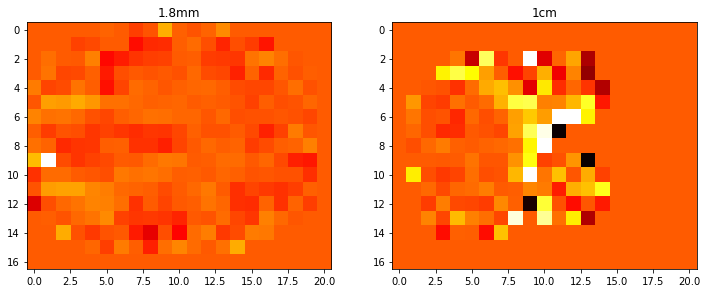

In [9]:
print(betas.shape)
print(downsampled_betas.shape)

import matplotlib.pyplot as plt

# Assume you want to visualize the slice at z=10 and at the first time point (t=0)
z_coordinate = 10
t_point = 10

# Extract the 2D slice from the original and downsampled data
original_slice = betas[t_point, :, :, z_coordinate]
downsampled_slice = downsampled_betas[t_point, :, :, z_coordinate // 5]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(original_slice, clim=(-3000,3000), cmap=plt.get_cmap('hot'))
axes[0].set_title('1.8mm')

axes[1].imshow(downsampled_slice, clim=(-3000,3000), cmap=plt.get_cmap('hot'))
axes[1].set_title('1cm')

plt.show()

In [28]:
original_slice.max()

23030

In [12]:
# load betas
f = h5py.File(f'betas_all_{subject}.hdf5', 'r')
betas = f['betas'][:]

# load orig images
# f = h5py.File(f'{tmp}/natural-scenes-dataset/nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5', 'r')
f = h5py.File('coco_images_224_float16.hdf5', 'r')
images = f['images'][:]

In [23]:
# def pull_samples_from_idx(indices,dataset=images):
#     indices = indices.long()
#     sort_order = torch.argsort(indices)
#     inverse_sort_order = torch.argsort(sort_order)

#     sorted_indices = indices[sort_order]
#     duplicate_idx = torch.where(sorted_indices[1:] == sorted_indices[:-1])[0]

#     sorted_images = images[np.unique(indices[sort_order])]

#     # add back in duplicates
#     for d in duplicate_idx:
#         sorted_images = np.insert(sorted_images, d, sorted_indices[d], axis=0)

#     return sorted_images[inverse_sort_order]

import random
import tarfile

batch_size = 32
num_total = 27750
def my_split_by_node(urls): return urls
    
train_url = f"{tmp}/mindeyev2_wds/subj01/train/" + "0.tar"
print(train_url)

train_data = wds.WebDataset(train_url,resampled=False,nodesplitter=my_split_by_node)\
                    .decode("torch")\
                    .rename(behav="behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "olds_behav"])
train_dl = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=True)

test_url = f"{tmp}/mindeyev2_wds/subj01/test/" + "0.tar"
print(test_url)
test_data = wds.WebDataset(test_url,resampled=False,nodesplitter=my_split_by_node)\
                    .decode("torch")\
                    .rename(behav="behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "olds_behav"])
test_dl = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True)

/scratch/gpfs/KNORMAN/mindeyev2_wds/subj01/train/0.tar
/scratch/gpfs/KNORMAN/mindeyev2_wds/subj01/test/0.tar


In [24]:
for train_i, (behav, old_behav) in enumerate(tqdm(train_dl,total=num_total//batch_size)):
#     # pull images from hdf5 (have to sort and unsort due to how hdf5 works)
#     image = images[behav[:,-1,0].long()]

#     # pull betas from hdf5 
#     voxel = betas[behav[:,-1,5].long()]
#     # memory_beta = pull_memory_samples_from_idx(behav[:,-1,5]-1,dataset=betas)
    
    if train_i < 1:
        # print(image.shape)
        # print(voxel.shape)
        print(behav.shape)
        print(old_behav.shape)
        print(behav[:,-1,0])
        print(behav[:,-1,2])
        print(behav[:,-1,4])
        break
        
print((train_i+1) * batch_size)

  0%|                                                   | 0/867 [00:00<?, ?it/s]

torch.Size([32, 33, 17])
torch.Size([32, 3, 17])
tensor([46002., 48617., 44980., 32625., 53052.,  4930., 32625.,  6431., 70335.,
        36576., 57046.,  7659., 30373., 25959., 30373., 44980., 65414., 42171.,
         5602., 21601., 62302.,  5301., 15492., 25287., 21601.,  6558., 70335.,
        16723., 40575., 45595., 53052.,  9917.], dtype=torch.float64)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)
tensor([ 1., 29., 36., 45., 56., 57., 28., 58.,  2.,  8., 28., 42., 49., 52.,
         1.,  2., 14., 44., 45., 58., 59., 62.,  1.,  6., 15., 18., 31., 32.,
        56., 33., 41., 44.], dtype=torch.float64)
32


In [31]:
behav[0,-1,[0,5]].long()

tensor([46002,     0])

In [32]:
bbehav[0,-1,[0,5]].long()

tensor([61882,     1])

In [33]:
betas.shape

(27750, 325803)

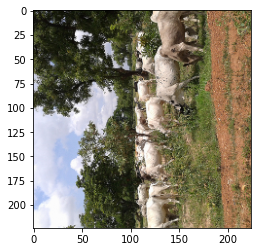

In [26]:
plt.imshow(images[46002].astype(np.float32).T)

# Transfer to HF

In [10]:
from huggingface_hub import notebook_login, upload_file
notebook_login()

In [11]:
from tqdm import tqdm
tmp = '/scratch/gpfs/KNORMAN'

subject = 'subj01'
sub = int(subject[-1])

nsessions_allsubj=np.array([40, 40, 32, 30, 40, 32, 40, 30])-3 # 3 sessions are withheld for algonauts 
nsessions=nsessions_allsubj[sub];
print(nsessions)

# for tar in tqdm(range(0,nsessions)):
#     upload_file(
#         path_or_fileobj=f"{tmp}/mindeyev2_wds/{subject}/train/{tar}.tar",
#         path_in_repo=f"wds/{subject}/train/{tar}.tar",
#         repo_id="pscotti/mindeyev2",
#         repo_type="dataset")
    
# upload_file(
#     path_or_fileobj=f"{tmp}/mindeyev2_wds/{subject}/test/0.tar",
#     path_in_repo=f"wds/{subject}/test/0.tar",
#     repo_id="pscotti/mindeyev2",
#     repo_type="dataset")

upload_file(
    path_or_fileobj=f'betas_{subject}_thresholded_wholebrain.hdf5',
    path_in_repo=f"betas_{subject}_thresholded_wholebrain.hdf5",
    repo_id="pscotti/mindeyev2",
    repo_type="dataset")

37


'https://huggingface.co/datasets/pscotti/mindeyev2/blob/main/betas_subj01_thresholded_wholebrain.hdf5'